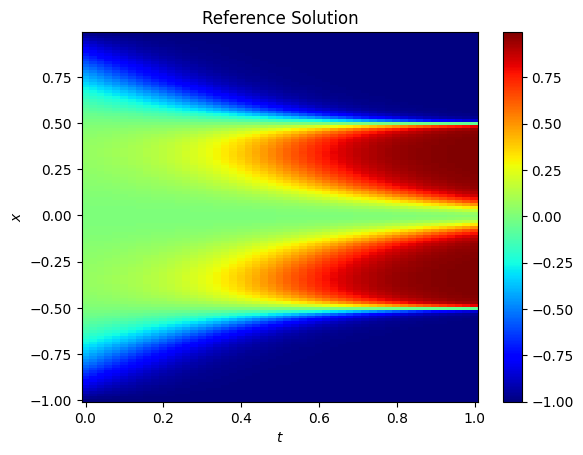

Model Summary:
params/Dense_0/kernel: shape=(2, 16), size=32
params/Dense_0/bias: shape=(16,), size=16
params/ResidualBlock_0/RMSNorm_0/scale: shape=(16,), size=16
params/ResidualBlock_0/MambaBlock_0/Dense_0/kernel: shape=(16, 64), size=1024
params/ResidualBlock_0/MambaBlock_0/Conv_0/kernel: shape=(4, 1, 32), size=128
params/ResidualBlock_0/MambaBlock_0/Conv_0/bias: shape=(32,), size=32
params/ResidualBlock_0/MambaBlock_0/Dense_1/kernel: shape=(32, 513), size=16416
params/ResidualBlock_0/MambaBlock_0/Dense_2/kernel: shape=(1, 32), size=32
params/ResidualBlock_0/MambaBlock_0/Dense_2/bias: shape=(32,), size=32
params/ResidualBlock_0/MambaBlock_0/A_log: shape=(32, 8), size=256
params/ResidualBlock_0/MambaBlock_0/D: shape=(32,), size=32
params/ResidualBlock_0/MambaBlock_0/Dense_3/kernel: shape=(32, 16), size=512
params/ResidualBlock_1/RMSNorm_0/scale: shape=(16,), size=16
params/ResidualBlock_1/MambaBlock_0/Dense_0/kernel: shape=(16, 64), size=1024
params/ResidualBlock_1/MambaBlock_0/Conv_

  4%|▍         | 1191/30000 [01:07<27:10, 17.66it/s, Loss=0.177, Loss_IC=0.111, Loss_Res=0.0667]


KeyboardInterrupt: 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from flax import linen as nn
from flax.core import freeze, unfreeze
from flax.traverse_util import flatten_dict
from dataclasses import dataclass
from typing import Union
import math
import matplotlib.pyplot as plt
import optax
from functools import partial
from tqdm import trange
import scipy.io

# Model Arguments
@dataclass
class ModelArgs:
    d_model: int = 64        # Hidden dimension
    n_layer: int = 2         # Number of layers
    d_state: int = 16        # Latent state dimension
    expand: int = 2          # Expansion factor
    dt_rank: Union[int, str] = 'auto'  # Rank of Δ
    d_conv: int = 4          # Convolution kernel size
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

# Root Mean Square Normalization
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        rms = jnp.sqrt(jnp.mean(jnp.square(x), axis=-1, keepdims=True) + self.eps)
        scale = self.param('scale', nn.initializers.ones, (self.d_model,))
        return x / rms * scale

# Mamba Block
class MambaBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        args = self.args
        d_model = args.d_model
        d_inner = args.d_inner
        d_state = args.d_state
        dt_rank = args.dt_rank

        # Input Projection
        x_and_res = nn.Dense(features=d_inner * 2, use_bias=args.bias)(x)
        x_proj, res = jnp.split(x_and_res, 2, axis=-1)

        # Depthwise Convolution over the sequence dimension
        x_conv = x_proj  # Shape: (batch_size, sequence_length, d_inner)

        x_conv = nn.Conv(
            features=d_inner,
            kernel_size=(args.d_conv,),
            feature_group_count=d_inner,
            padding='SAME',  # Use 'SAME' padding to maintain the sequence length
            use_bias=args.conv_bias
        )(x_conv)

        x = nn.gelu(x_conv)

        # Compute delta, B, C
        x_dbl = nn.Dense(features=dt_rank + 2 * d_state * d_inner, use_bias=False)(x)
        delta, B_C = jnp.split(x_dbl, [dt_rank], axis=-1)
        (b, l, _) = delta.shape

        # Reshape B_C to separate B and C
        B_C = B_C.reshape(b, l, d_inner, 2 * d_state)
        B, C = jnp.split(B_C, 2, axis=-1)  # Shapes: (b, l, d_inner, d_state)

        delta = nn.softplus(nn.Dense(features=d_inner)(delta))  # Shape: (b, l, d_inner)

        # State Space Parameters
        A_log = self.param('A_log', nn.initializers.normal(), (d_inner, d_state))
        D = self.param('D', nn.initializers.ones, (d_inner,))
        A = -jnp.exp(A_log)

        y = self.ssm(x, delta, A, B, C, D)
        y = y * nn.gelu(res)
        output = nn.Dense(features=d_model, use_bias=args.bias)(y)
        return output

    def ssm(self, x, delta, A, B, C, D):
        """State Space Model computation."""
        (b, l, d) = x.shape
        n = A.shape[1]

        # Discretize A
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bldn,bld->bldn', delta, B, x)

        # Initialize state
        x_state = jnp.zeros((b, d, n))

        # Scan over time steps
        def scan_fn(carry, inputs):
            x_prev = carry
            deltaA_t, deltaB_u_t = inputs
            x_t = deltaA_t * x_prev + deltaB_u_t
            return x_t, x_t

        deltaA_list = deltaA.transpose(1, 0, 2, 3)  # (sequence_length, batch_size, d, n)
        deltaB_u_list = deltaB_u.transpose(1, 0, 2, 3)  # (sequence_length, batch_size, d, n)
        inputs = (deltaA_list, deltaB_u_list)
        _, x_states = jax.lax.scan(scan_fn, x_state, inputs)
        x_states = x_states.transpose(1, 0, 2, 3)  # Back to (batch_size, sequence_length, d, n)

        y = jnp.einsum('bldn,bldn->bld', x_states, C)
        y = y + x * D[None, None, :]
        return y

# Residual Block
class ResidualBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        norm = RMSNorm(self.args.d_model)
        x_norm = norm(x)
        mixer = MambaBlock(self.args)
        y = mixer(x_norm)
        return x + y

# Mamba Model
class Mamba(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        # x has shape (batch_size, sequence_length, input_dim)
        # Project input to d_model dimensions
        x = nn.Dense(features=self.args.d_model)(x)

        # Apply Residual Blocks
        for i in range(self.args.n_layer):
            x = ResidualBlock(self.args)(x)

        # Final normalization
        x = RMSNorm(self.args.d_model)(x)

        # Output layer
        logits = nn.Dense(features=1)(x)
        return logits  # Shape (batch_size, sequence_length, 1)

# PINN for the Allen-Cahn Equation
class MambaPINN:
    def __init__(self, key, args, t_rv, x_rv, t_ic, x_ic, u_ic, nu):
        self.model = Mamba(args)
        self.key = key
        input_shape = (t_rv.shape[0], t_rv.shape[1], 2)  # (batch_size, sequence_length, 2)
        dummy_input = jnp.ones(input_shape)
        self.params = self.model.init(self.key, dummy_input)
        self.t_rv = t_rv  # Shape (batch_size, sequence_length)
        self.x_rv = x_rv  # Shape (batch_size, sequence_length)
        self.t_ic = t_ic  # Shape (batch_size, sequence_length=1)
        self.x_ic = x_ic  # Shape (batch_size, sequence_length=1)
        self.u_ic = u_ic  # Shape (batch_size, sequence_length=1)
        self.nu = nu  # Diffusion coefficient
        self.optimizer = optax.adam(learning_rate=1e-3)
        self.opt_state = self.optimizer.init(self.params)

        # Initialize logs for losses
        self.loss_log = []
        self.loss_ic_log = []
        self.loss_res_log = []

        # Print model summary
        self.print_model_summary()

    def neural_net(self, params, t, x):
        inputs = jnp.stack([t, x], axis=-1)  # Shape (batch_size, sequence_length, 2)
        u_pred = self.model.apply(params, inputs)
        return u_pred.squeeze(-1)  # Remove the last dimension

    def residual_net(self, params, t, x):
        # Flatten t and x
        t_flat = t.reshape(-1)
        x_flat = x.reshape(-1)

        # Define scalar function
        def u_fn(t, x):
            inputs = jnp.array([[[t, x]]])  # Shape (1, 1, 2)
            u_pred = self.model.apply(params, inputs)  # Shape (1, 1, 1)
            return u_pred[0, 0, 0]  # Return scalar

        # Vectorize functions
        u_fn_vec = vmap(u_fn, in_axes=(0, 0))
        u_t_fn = vmap(grad(u_fn, argnums=0), in_axes=(0, 0))
        u_xx_fn = vmap(lambda t, x: grad(lambda x: grad(u_fn, argnums=1)(t, x))(x), in_axes=(0, 0))

        # Compute values and gradients
        u_flat = u_fn_vec(t_flat, x_flat)
        u_t_flat = u_t_fn(t_flat, x_flat)
        u_xx_flat = u_xx_fn(t_flat, x_flat)

        # Reshape back to original shape
        u = u_flat.reshape(t.shape)
        u_t = u_t_flat.reshape(t.shape)
        u_xx = u_xx_flat.reshape(t.shape)

        # Compute residual
        residual = u_t - self.nu * u_xx + 5 * u ** 3 - 5 * u
        return residual

    @partial(jit, static_argnums=0)
    def loss(self, params):
        # Residual loss
        res_r = self.residual_net(params, self.t_rv, self.x_rv)
        loss_r = jnp.mean(jnp.square(res_r))

        # Initial condition loss
        u_pred_ic = self.neural_net(params, self.t_ic, self.x_ic)
        loss_ic = jnp.mean(jnp.square(u_pred_ic - self.u_ic))

        loss = loss_r + loss_ic
        return loss

    @partial(jit, static_argnums=0)
    def loss_ic(self, params):
        u_pred_ic = self.neural_net(params, self.t_ic, self.x_ic)
        loss_ic = jnp.mean(jnp.square(u_pred_ic - self.u_ic))
        return loss_ic

    @partial(jit, static_argnums=0)
    def loss_res(self, params):
        res_r = self.residual_net(params, self.t_rv, self.x_rv)
        loss_r = jnp.mean(jnp.square(res_r))
        return loss_r

    @partial(jit, static_argnums=0)
    def update(self, params, opt_state):
        loss_value, grads = jax.value_and_grad(self.loss)(params)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    def train(self, num_iter):
        params = self.params
        opt_state = self.opt_state

        pbar = trange(num_iter)
        for it in pbar:
            params, opt_state, loss_value = self.update(params, opt_state)

            if it % 100 == 0:
                # Compute additional loss components
                loss_ic_value = self.loss_ic(params)
                loss_res_value = self.loss_res(params)

                # Log the losses
                self.loss_log.append(float(loss_value))
                self.loss_ic_log.append(float(loss_ic_value))
                self.loss_res_log.append(float(loss_res_value))

                # Update progress bar
                pbar.set_postfix({'Loss': float(loss_value), 
                                  'Loss_IC': float(loss_ic_value), 
                                  'Loss_Res': float(loss_res_value)})
        self.params = params

    def predict(self, t_star, x_star):
        params = self.params
        inputs = jnp.stack([t_star, x_star], axis=-1)  # Shape (batch_size, sequence_length, 2)
        u_pred = self.model.apply(params, inputs)
        return u_pred.squeeze(-1)  # Shape (batch_size, sequence_length)

    def print_model_summary(self):
        params = self.params
        flat_params = flatten_dict(params)
        total_params = 0
        print("Model Summary:")
        for path, param in flat_params.items():
            print(f"{'/'.join(path)}: shape={param.shape}, size={param.size}")
            total_params += param.size
        print(f"Total parameters: {total_params}")

# Load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']  # Shape (n_x, n_t)
t_star = data['tt'][0]  # Shape (n_t,)
x_star = data['x'][0]  # Shape (n_x,)

# Downsample data
usol = usol[::4, ::4]  # downsample x and t dimensions
t_star = t_star[::4]
x_star = x_star[::4]

TT, XX = np.meshgrid(t_star, x_star)  # Shapes (n_x, n_t)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Reference Solution')
plt.show()

# Prepare data for MambaPINN
t0 = 0.0
t1 = 1.0

# Use the downsampled t_star and x_star
n_t = len(t_star)
n_x = len(x_star)

# Residual points
t_r = t_star  # Shape (n_t,)
x_r = x_star  # Shape (n_x,)
TT_r, XX_r = np.meshgrid(t_r, x_r)
t_rv = TT_r  # Shape (n_x, n_t)
x_rv = XX_r  # Shape (n_x, n_t)

# Initial condition points
t_ic = np.zeros_like(x_star)  # Shape (n_x,)
x_ic = x_star  # Shape (n_x,)
u_ic = usol[:, 0]  # Shape (n_x,)

# Reshape initial condition data
t_ic = t_ic[:, None]  # Shape (n_x, 1)
x_ic = x_ic[:, None]  # Shape (n_x, 1)
u_ic = u_ic[:, None]  # Shape (n_x, 1)

# Set nu parameter
nu = 0.0001

# Model arguments
args = ModelArgs(
    d_model=16,
    n_layer=2,
    d_state=8,
    expand=2,
    dt_rank='auto',
    d_conv=4,
    conv_bias=True,
    bias=False
)

# Create PRNG key
key = random.PRNGKey(1234)

# Initialize the MambaPINN model
model = MambaPINN(key, args, t_rv, x_rv, t_ic, x_ic, u_ic, nu)

# Train the model
model.train(num_iter=30000)




In [2]:
import jax
import numpy as np
from flax import linen as nn
from clu import parameter_overview

class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x

key = jax.random.PRNGKey(0)
variables = CNN().init(key, np.random.randn(1, 32, 32, 3))
print(parameter_overview.get_parameter_overview(variables))

SyntaxError: invalid syntax (parameter_overview.py, line 174)

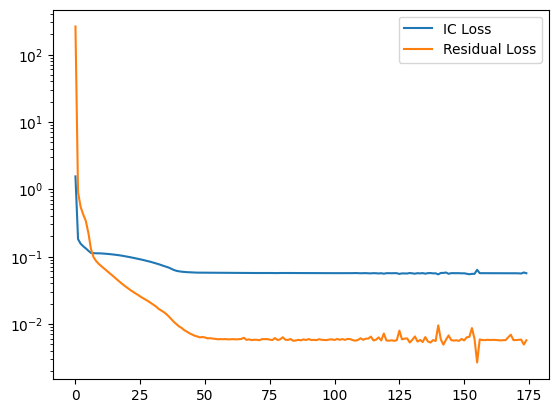

Relative L2 error: 2.401e+00


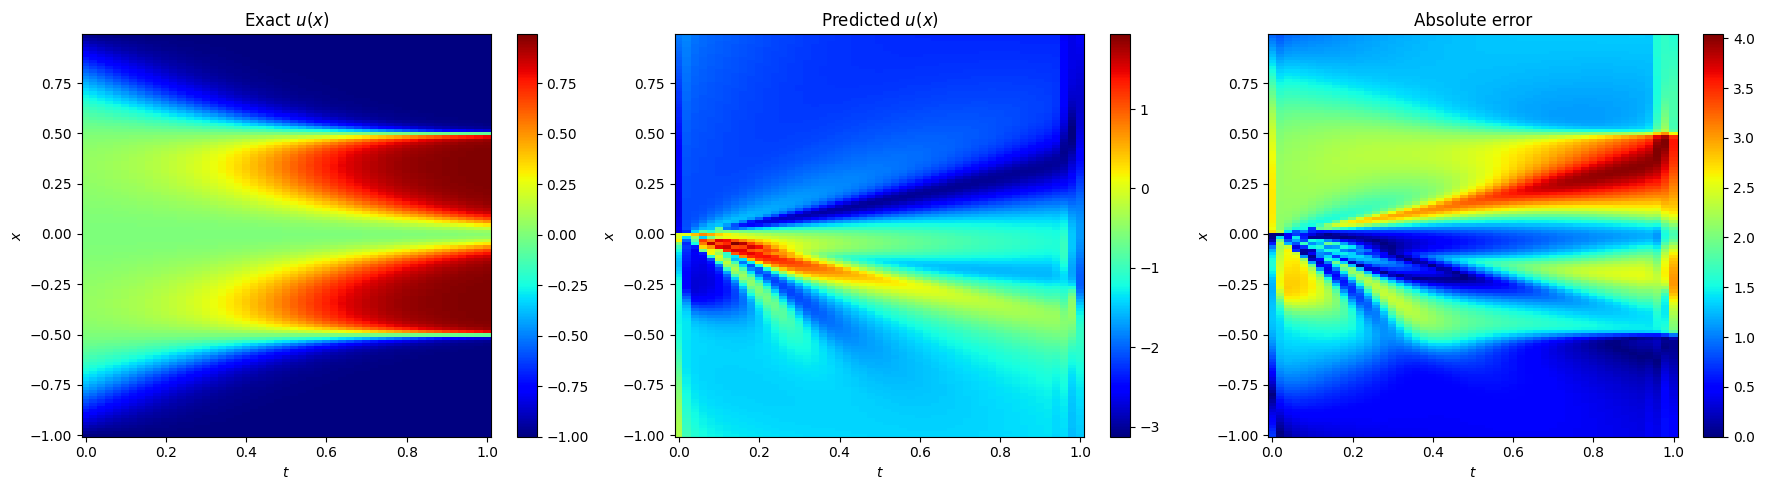

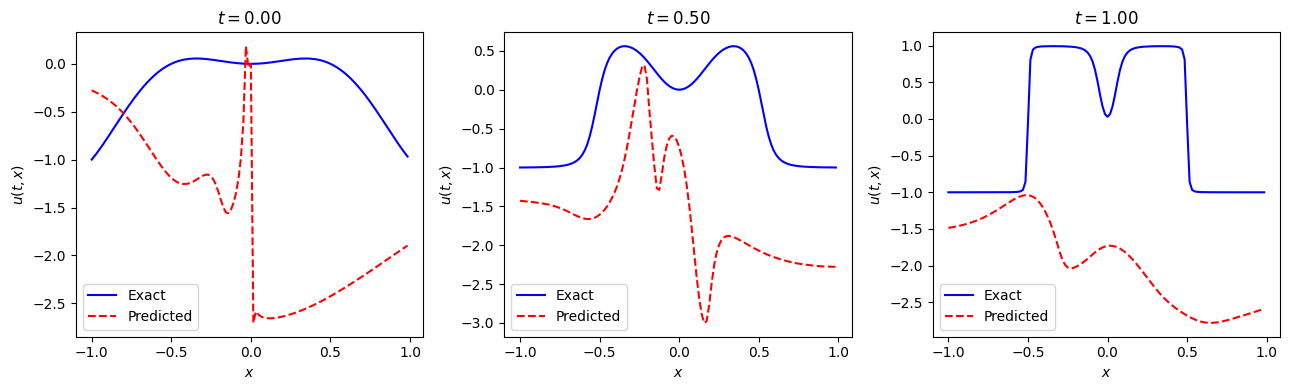

In [8]:
# Plot the loss logs
plt.plot(model.loss_ic_log, label='IC Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.legend()
plt.show()

# Predict using the trained model
TT_pred, XX_pred = np.meshgrid(t_star, x_star)
t_pred = TT_pred
x_pred = XX_pred

u_pred = model.predict(t_pred, x_pred)

# Compute the relative L2 error
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot the results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

# Plot slices at specific times
idx_t0 = 0  # t=0
idx_t1 = usol.shape[1] // 2  # t=middle time
idx_t2 = -1  # t=last time

fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:, idx_t0], color='blue', label='Exact')
plt.plot(x_star, u_pred[:, idx_t0], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = {:.2f}$'.format(t_star[idx_t0]))
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:, idx_t1], color='blue', label='Exact')
plt.plot(x_star, u_pred[:, idx_t1], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = {:.2f}$'.format(t_star[idx_t1]))
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:, idx_t2], color='blue', label='Exact')
plt.plot(x_star, u_pred[:, idx_t2], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = {:.2f}$'.format(t_star[idx_t2]))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Imports
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from flax import linen as nn
from flax.core import freeze, unfreeze
from dataclasses import dataclass
from typing import Union
import math
import numpy as np
import matplotlib.pyplot as plt
import optax
from functools import partial
from tqdm import trange

# Model Arguments
@dataclass
class ModelArgs:
    d_model: int = 64        # Hidden dimension
    n_layer: int = 2         # Number of layers
    d_state: int = 16        # Latent state dimension
    expand: int = 2          # Expansion factor
    dt_rank: Union[int, str] = 'auto'  # Rank of Δ
    d_conv: int = 4          # Convolution kernel size
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

# Root Mean Square Normalization
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        rms = jnp.sqrt(jnp.mean(jnp.square(x), axis=-1, keepdims=True) + self.eps)
        scale = self.param('scale', nn.initializers.ones, (self.d_model,))
        return x / rms * scale

# Mamba Block
class MambaBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        args = self.args
        d_model = args.d_model
        d_inner = args.d_inner
        d_state = args.d_state
        dt_rank = args.dt_rank

        # Input Projection
        x_and_res = nn.Dense(features=d_inner * 2, use_bias=args.bias)(x)
        x_proj, res = jnp.split(x_and_res, 2, axis=-1)

        # Depthwise Convolution over the sequence dimension
        x_conv = x_proj  # Shape: (batch_size, sequence_length, d_inner)

        x_conv = nn.Conv(
            features=d_inner,
            kernel_size=(args.d_conv,),
            feature_group_count=d_inner,
            padding='SAME',  # Use 'SAME' padding to maintain the sequence length
            use_bias=args.conv_bias
        )(x_conv)

        x = nn.gelu(x_conv)

        # Compute delta, B, C
        x_dbl = nn.Dense(features=dt_rank + 2 * d_state * d_inner, use_bias=False)(x)
        delta, B_C = jnp.split(x_dbl, [dt_rank], axis=-1)
        (b, l, _) = delta.shape

        # Reshape B_C to separate B and C
        B_C = B_C.reshape(b, l, d_inner, 2 * d_state)
        B, C = jnp.split(B_C, 2, axis=-1)  # Shapes: (b, l, d_inner, d_state)

        delta = nn.softplus(nn.Dense(features=d_inner)(delta))  # Shape: (b, l, d_inner)

        # State Space Parameters
        A_log = self.param('A_log', nn.initializers.normal(), (d_inner, d_state))
        D = self.param('D', nn.initializers.ones, (d_inner,))
        A = -jnp.exp(A_log)

        y = self.ssm(x, delta, A, B, C, D)
        y = y * nn.gelu(res)
        output = nn.Dense(features=d_model, use_bias=args.bias)(y)
        return output

    def ssm(self, x, delta, A, B, C, D):
        """State Space Model computation."""
        (b, l, d) = x.shape
        n = A.shape[1]

        # Discretize A
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bldn,bld->bldn', delta, B, x)

        # Initialize state
        x_state = jnp.zeros((b, d, n))

        # Scan over time steps
        def scan_fn(carry, inputs):
            x_prev = carry
            deltaA_t, deltaB_u_t = inputs
            x_t = deltaA_t * x_prev + deltaB_u_t
            return x_t, x_t

        deltaA_list = deltaA.transpose(1, 0, 2, 3)  # (sequence_length, batch_size, d, n)
        deltaB_u_list = deltaB_u.transpose(1, 0, 2, 3)  # (sequence_length, batch_size, d, n)
        inputs = (deltaA_list, deltaB_u_list)
        _, x_states = jax.lax.scan(scan_fn, x_state, inputs)
        x_states = x_states.transpose(1, 0, 2, 3)  # Back to (batch_size, sequence_length, d, n)

        y = jnp.einsum('bldn,bldn->bld', x_states, C)
        y = y + x * D[None, None, :]
        return y

# Residual Block
class ResidualBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        norm = RMSNorm(self.args.d_model)
        x_norm = norm(x)
        mixer = MambaBlock(self.args)
        y = mixer(x_norm)
        return x + y

# Mamba Model
class Mamba(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        # x has shape (batch_size, sequence_length, input_dim)
        # Project input to d_model dimensions
        x = nn.Dense(features=self.args.d_model)(x)

        # Apply Residual Blocks
        for _ in range(self.args.n_layer):
            x = ResidualBlock(self.args)(x)

        # Final normalization
        x = RMSNorm(self.args.d_model)(x)

        # Output layer
        logits = nn.Dense(features=1)(x)
        return logits  # Shape (batch_size, sequence_length, 1)

# PINN for the Allen-Cahn Equation
class MambaPINN:
    def __init__(self, key, args, t_rv, x_rv, t_ic, x_ic, u_ic, nu):
        self.model = Mamba(args)
        self.key = key
        input_shape = (t_rv.shape[0], t_rv.shape[1], 2)  # (batch_size, sequence_length, 2)
        dummy_input = jnp.ones(input_shape)
        self.params = self.model.init(self.key, dummy_input)
        self.t_rv = t_rv  # Shape (batch_size, sequence_length)
        self.x_rv = x_rv  # Shape (batch_size, sequence_length)
        self.t_ic = t_ic[:, None]  # Shape (batch_size, sequence_length=1)
        self.x_ic = x_ic[:, None]  # Shape (batch_size, sequence_length=1)
        self.u_ic = u_ic[:, None]  # Shape (batch_size, sequence_length=1)
        self.nu = nu  # Diffusion coefficient
        self.optimizer = optax.adam(learning_rate=1e-3)
        self.opt_state = self.optimizer.init(self.params)

        # Initialize logs for losses
        self.loss_log = []
        self.loss_ic_log = []
        self.loss_res_log = []

    def neural_net(self, params, t, x):
        inputs = jnp.stack([t, x], axis=-1)  # Shape (batch_size, sequence_length, 2)
        u_pred = self.model.apply(params, inputs)
        return u_pred.squeeze(-1)  # Remove the last dimension

    def residual_net(self, params, t, x):
        # Flatten t and x
        t_flat = t.reshape(-1)
        x_flat = x.reshape(-1)

        # Define scalar function
        def u_fn(t, x):
            inputs = jnp.array([[[t, x]]])  # Shape (1, 1, 2)
            u_pred = self.model.apply(params, inputs)  # Shape (1, 1, 1)
            return u_pred[0, 0, 0]  # Return scalar

        # Vectorize functions
        u_fn_vec = vmap(u_fn, in_axes=(0, 0))
        u_t_fn = vmap(grad(u_fn, argnums=0), in_axes=(0, 0))
        u_xx_fn = vmap(lambda t, x: grad(lambda x: grad(u_fn, argnums=1)(t, x))(x), in_axes=(0, 0))

        # Compute values and gradients
        u_flat = u_fn_vec(t_flat, x_flat)
        u_t_flat = u_t_fn(t_flat, x_flat)
        u_xx_flat = u_xx_fn(t_flat, x_flat)

        # Reshape back to original shape
        u = u_flat.reshape(t.shape)
        u_t = u_t_flat.reshape(t.shape)
        u_xx = u_xx_flat.reshape(t.shape)

        # Compute residual
        residual = u_t - self.nu * u_xx + 5 * u ** 3 - 5 * u
        return residual

    @partial(jit, static_argnums=0)
    def loss(self, params):
        # Residual loss
        res_r = self.residual_net(params, self.t_rv, self.x_rv)
        loss_r = jnp.mean(jnp.square(res_r))

        # Initial condition loss
        u_pred_ic = self.neural_net(params, self.t_ic, self.x_ic)
        loss_ic = jnp.mean(jnp.square(u_pred_ic - self.u_ic))

        loss = loss_r + loss_ic
        return loss

    @partial(jit, static_argnums=0)
    def loss_ic(self, params):
        u_pred_ic = self.neural_net(params, self.t_ic, self.x_ic)
        loss_ic = jnp.mean(jnp.square(u_pred_ic - self.u_ic))
        return loss_ic

    @partial(jit, static_argnums=0)
    def loss_res(self, params):
        res_r = self.residual_net(params, self.t_rv, self.x_rv)
        loss_r = jnp.mean(jnp.square(res_r))
        return loss_r

    @partial(jit, static_argnums=0)
    def update(self, params, opt_state):
        loss_value, grads = jax.value_and_grad(self.loss)(params)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    def train(self, num_iter):
        params = self.params
        opt_state = self.opt_state

        pbar = trange(num_iter)
        for it in pbar:
            params, opt_state, loss_value = self.update(params, opt_state)

            if it % 100 == 0:
                # Compute additional loss components
                loss_ic_value = self.loss_ic(params)
                loss_res_value = self.loss_res(params)

                # Log the losses
                self.loss_log.append(float(loss_value))
                self.loss_ic_log.append(float(loss_ic_value))
                self.loss_res_log.append(float(loss_res_value))

                # Update progress bar
                pbar.set_postfix({'Loss': float(loss_value), 
                                  'Loss_IC': float(loss_ic_value), 
                                  'Loss_Res': float(loss_res_value)})
        self.params = params

    def predict(self, t_star, x_star):
        params = self.params
        inputs = jnp.stack([t_star, x_star], axis=-1)  # Shape (batch_size, sequence_length, 2)
        u_pred = self.model.apply(params, inputs)
        return u_pred.squeeze(-1)  # Shape (batch_size, sequence_length)

# Data Preparation
# Define the initial condition function
def initial_condition(x):
    return np.cos(np.pi * x)

# Residual points (creating a batch of sequences)
t_r = np.linspace(0, 1, 100)  # sequence_length
x_r = np.linspace(-1, 1, 256)  # batch_size

t_rv, x_rv = np.meshgrid(t_r, x_r)  # t_rv and x_rv have shape (batch_size, sequence_length)
t_ic = np.zeros_like(x_r)  # Initial time (t=0) for all x
x_ic = x_r  # All x positions at initial time
u_ic = initial_condition(x_ic)

# Convert to JAX arrays
t_rv = jnp.array(t_rv)
x_rv = jnp.array(x_rv)
t_ic = jnp.array(t_ic)
x_ic = jnp.array(x_ic)
u_ic = jnp.array(u_ic)

# Model arguments
args = ModelArgs(
    d_model=64,
    n_layer=2,
    d_state=16,
    expand=2,
    dt_rank='auto',
    d_conv=4,
    conv_bias=True,
    bias=False
)

# Initialize the model
key = random.PRNGKey(0)
nu = 0.0001
model = MambaPINN(key, args, t_rv, x_rv, t_ic, x_ic, u_ic, nu)

# Train the model
model.train(num_iter=1000)

# Prediction and Visualization
# Test points
t_star = np.linspace(0, 1, 100)  # sequence_length
x_star = np.linspace(-1, 1, 256)  # batch_size

t_test, x_test = np.meshgrid(t_star, x_star)
t_test = jnp.array(t_test)
x_test = jnp.array(x_test)

# Make predictions
u_pred = model.predict(t_test, x_test)  # Shape (batch_size, sequence_length)

# Compute the true solution numerically
def compute_true_solution(t_star, x_star, nu):
    """
    Computes the true solution of the Allen-Cahn equation using finite difference method.
    """
    # Parameters
    Nx = len(x_star)
    Nt = len(t_star)
    dx = x_star[1] - x_star[0]
    dt = t_star[1] - t_star[0]

    # Stability condition for explicit method
    stability_limit = dx**2 / (2 * nu)
    if dt > stability_limit:
        print("Warning: Time step exceeds stability limit for explicit method.")

    # Initialize solution array
    u_true = np.zeros((Nx, Nt))
    u_true[:, 0] = initial_condition(x_star)

    # Dirichlet boundary conditions
    u_true[0, :] = 0
    u_true[-1, :] = 0

    # Time-stepping loop
    for n in range(Nt - 1):
        u = u_true[:, n]
        # Compute spatial second derivative
        u_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2

        # Nonlinear term
        f = -5 * u**3 + 5 * u

        # Update solution
        u_new = u + dt * (nu * u_xx + f)
        # Apply boundary conditions
        u_new[0] = 0
        u_new[-1] = 0
        # Store the new solution
        u_true[:, n + 1] = u_new

    return u_true

# Compute the true solution
u_true = compute_true_solution(t_star, x_star, nu)

# Compute the difference between predicted and true solution
u_diff = u_pred - u_true

# Plotting the results
plt.figure(figsize=(18, 6))

# Predicted Solution
plt.subplot(1, 3, 1)
plt.pcolor(t_star, x_star, u_pred, shading='auto')
plt.colorbar(label='u_pred(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted Solution u_pred(t, x)')

# True Solution
plt.subplot(1, 3, 2)
plt.pcolor(t_star, x_star, u_true, shading='auto')
plt.colorbar(label='u_true(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('True Solution u_true(t, x)')

# Difference
plt.subplot(1, 3, 3)
plt.pcolor(t_star, x_star, u_diff, shading='auto')
plt.colorbar(label='Difference')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Difference u_pred - u_true')

plt.tight_layout()
plt.show()

print((u_diff**2).mean().item())